# Functions

In [1]:
# All Libraries Needed
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

PATH = '../data/pc/'

URL = "https://michael-weylandt.com/STA9890/competition_data/"

In [2]:
# Read in csv files from site
def read_gh(URL, f):
    return pd.read_csv(URL + f)

# Groups "rare" (low frequency) items from a column
def group_rare_categories(df, column, threshold=100, new_label='Other'):
    """
    Replace categories in a column that appear fewer than `threshold` times with `new_label`.

    Args:
        df (pd.DataFrame): DataFrame to process
        column (str): Name of the column to transform
        threshold (int): Frequency threshold below which values are replaced
        new_label (str): Label to replace rare categories with

    Returns:
        pd.DataFrame: Updated DataFrame with rare values grouped
    """
    value_counts = df[column].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    df[column] = df[column].apply(lambda x: new_label if x in rare_values else x)
    return df

# Cleans the Building DATAFRAME files
def clean_building_dfs(df):
    tfcols = ['elevator','has_cooling','has_heat']
    for col in tfcols:
        df[col] = df[col].fillna(0).astype(int)

    quality_map = {
    'F':0,
    'E':1,
    'D':2,
    'C':3,
    'B':4,
    'A':5,
    'X':6
    }

    df['quality'] = df['quality'].map(quality_map)

    quality_description_map = {
        'Poor':0,
        'Very Low':1,
        'Low':2,
        'Average':3,
        'Good':4,
        'Excellent':5,
        'Superior':6
    }

    df['quality_description'] = df['quality_description'].map(quality_description_map)

    bc_map = {
        'Unsound':0,
        'Very Poor':1,
        'Poor':2,
        'Fair':3,
        'Average':4,
        'Good':5,
        'Very Good':6,
        'Excellent':7
    }

    df['building_condition'] = df['building_condition'].map(bc_map)

    grade_map = {
        'E-':1.3,
        'E':1.6,
        'E+':1.9,
        'D-':2.3,
        'D':2.6,
        'D+':2.9,
        'C-':3.3,
        'C':3.6,
        'C+':3.9,
        'B-':4.3,
        'B':4.6,
        'B+':4.9,
        'A-':5.3,
        'A':5.6,
        'A+':5.9,
        'X-':6.3,
        'X':6.6,
        'X+':6.9
    }

    df['grade'] = df['grade'].map(grade_map)

    pc_map = {
        'Unsound':0,
        'Very Poor':1,
        'Poor':2,
        'Fair':3,
        'Average':4,
        'Good':5,
        'Very Good':6,
        'Excellent':7
    }

    df['physical_condition'] = df['physical_condition'].map(pc_map)

    df.loc[df['foundation_type'] == 'Basement and Basement', 'foundation_type'] = 'Basement'

    df.loc[(df['foundation_type']=='Basement and Slab')|(df['foundation_type']=='Crawl Space and Slab')|(df['foundation_type']=='Basement and Crawl Space')|
           (df['foundation_type']=='Basement and Pier and Beam')|(df['foundation_type']=='Pier and Beam')|
           (df['foundation_type']=='Pier and Beam and Pier and Beam')|(df['foundation_type']=='Pier and Beam and Slab'),'foundation_type'] = 'Mixed'

    dummies = pd.get_dummies(df['foundation_type'], prefix='foundation').astype('Int64')
    df = pd.concat([df, dummies], axis=1)

    df = group_rare_categories(df, 'exterior_walls', threshold=1000, new_label='Other')

    # Keywords to extract
    keywords = [
        'Brick Veneer',
        'Brick Masonry',
        'Concrete Block',
        'Vinyl',
        'Stucco',
        'Stone',
        'Other'
    ]

    # Create 1/0 dummy columns based on substring presence
    for key in keywords:
        col_name = key.replace(' ', '_').lower()  # e.g., 'Brick Veneer' → 'brick_veneer'
        df[col_name] = df['exterior_walls'].fillna('').str.contains(key).astype('int8')

    df = df.drop(['exterior_walls','foundation_type'],axis=1)

    return df

# appends new accounts to running list of unique accounts
def append_new_accts(df_base, df_new, year):
    existing_accts = set(df_base['acct'])
    new_entries = df_new[~df_new['acct'].isin(existing_accts)][['acct']].copy()
    new_entries['year'] = year
    return pd.concat([df_base,new_entries],ignore_index=True)

# Function to count occurrances of a specific string value
def count_values(df,value:str):

    """
    Returns printout of whatever character you're looking for across the dataset
    """

    total_rows = len(df)
    val_counts = []

    for col in df.columns:
        count = (df[col] == value).sum()
        if count > 0:
            percent = (count / total_rows) * 100
            val_counts.append((col, count, percent))

    # Sort by count descending
    val_counts.sort(key=lambda x: x[1], reverse=True)

    # Print results
    print(f"{'Column':<30} {'? Count':>15} {'% of Rows':>12}")
    print("-" * 60)
    for col, count, percent in val_counts:
        print(f"{col:<30} {count:>15,} {percent:>11.2f}%")
        
# function to count NULLs in the columns of a df
def count_nulls(df, top_n=10):
    total_rows = len(df)
    null_counts = []

    for col in df.columns:
        count = df[col].isna().sum()
        if count > 0:
            percent = (count / total_rows) * 100
            null_counts.append((col, count, percent))

    # Sort by null count descending
    null_counts.sort(key=lambda x: x[1], reverse=True)

    # Print total number of columns with NULLs
    print(f"Total number of columns with NULLs: {len(null_counts)}\n")

    # If there are NULLs, display formatted table
    if null_counts:
        print(f"{'Column':<30} {'NULL Count':>15} {'% of Rows':>12}")
        print("-" * 60)
        for col, count, percent in null_counts[:top_n]:
            print(f"{col:<30} {count:>15,} {percent:>11.2f}%")
    else:
        print("No NULLs found in the DataFrame.")

# create model printout
def model_scores():

    data = {
      'Model': [
          'OLS', 'LASSO', 'Ridge', 'RidgeCV',
          'XGBR','XGBR_GS','LGBM','Ensemble',
          'Stack_1','Stack_2','Stack_3'
          ],
      'Train RMSE': [
          42103.47, 48757.61, 42101.38, 42101.38,
          24121.34, 40700.99, 42000.00, 41068.07,
          43313.99, 37393.21, 33441.12
          ],
      'Test RMSE (Public)': [
          48478.35, 46676.85, 48857.30, 47080.00,
          42143.88, 43196.91, 170263.72, 44709.20,
          43589.06, 42896.77, 45241.33
          ],
      'Test RMSE (Private)': [
          46903.05, 45345.82, 47746.13, 45075.56,
          43759.64, 44054.83, 174621.3, 44458.82,
          44946.14, 44380.56, 44128.42
          ]
      }

    df = pd.DataFrame(data)

    df_melted = df.melt(id_vars='Model', value_vars=['Train RMSE', 'Test RMSE (Public)', 'Test RMSE (Private)'],
                    var_name='Metric', value_name='RMSE')

    sns.set(style="whitegrid", rc={"axes.facecolor": "#ebebeb"})  # slightly grayer

    plt.figure(figsize=(14, 6))
    # sns.set(style="whitegrid", rc={"axes.facecolor": "#d3d3d3"})  # slightly darker gray
    sns.set(style="whitegrid", rc={
      "axes.facecolor": "#d3d3d3",    # inside the plot
      "figure.facecolor": "#d3d3d3",  # everything around it
      "grid.color": "black",
      "grid.linewidth": 0.5
    })

    bar = sns.barplot(data=df_melted, x='Model', y='RMSE', hue='Metric', palette='mako')

    # Add value labels
    # for p in bar.patches:
    #     height = p.get_height()
    #     if not pd.isna(height):
    #         bar.annotate(f'{height:,.0f}',
    #                      (p.get_x() + p.get_width() / 2, height),
    #                      ha='center', va='bottom', fontsize=9)

    # Add horizontal line for best (lowest) Test RMSE
    min_test_rmse_pub = df['Test RMSE (Public)'].min()
    plt.axhline(min_test_rmse_pub, linestyle='--', color='darkgreen', linewidth=1.5, label='Best Test RMSE (Public) = 42,144')

    # same but for private leaderboard
    min_test_rmse_priv = df['Test RMSE (Private)'].min()
    plt.axhline(min_test_rmse_priv, linestyle='--', color='darkblue', linewidth=1.5, label='Best Test RMSE (Private) = 43,760')

    plt.grid(True, color='black', linewidth=0.5)

    # Bold titles and labels
    plt.legend()
    plt.title("Train vs Test RMSE by Model", fontweight='bold', fontsize=14)
    plt.ylabel("RMSE", fontweight='bold')
    plt.xlabel("Model", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show();

# Data

In [3]:
# read in from prof's website
BUILDING_DETAILS_2015 = read_gh(URL, "building_details_2015.csv.gz")
BUILDING_DETAILS_2016 = read_gh(URL, "building_details_2016.csv.gz")
BUILDING_DETAILS_2017 = read_gh(URL, "building_details_2017.csv.gz")
BUILDING_DETAILS_2018 = read_gh(URL, "building_details_2018.csv.gz")
BUILDING_DETAILS_2019 = read_gh(URL, "building_details_2019.csv.gz")

In [4]:
df15 = clean_building_dfs(BUILDING_DETAILS_2015)
df16 = clean_building_dfs(BUILDING_DETAILS_2016)
df17 = clean_building_dfs(BUILDING_DETAILS_2017)
df18 = clean_building_dfs(BUILDING_DETAILS_2018)
df19 = clean_building_dfs(BUILDING_DETAILS_2019)

In [5]:
df_long = df15[['acct']].copy()
df_long['year'] = 2015

for df, yr in zip([df16, df17, df18, df19], [2016, 2017, 2018, 2019]):
    df_long = append_new_accts(df_long, df, yr)

In [7]:
static_cols = [
    'year_built',
    'foundation_Basement',
    'foundation_Crawl Space',
    'foundation_Slab',
    'foundation_Mixed'
]

year_df_map = {
    2015: df15,
    2016: df16,
    2017: df17,
    2018: df18,
    2019: df19
}

for col in static_cols:
    df_long[col] = np.nan
    
for year, df_source in year_df_map.items():
    # Get only accounts from df_long for that year
    acct_subset = df_long[df_long['year'] == year][['acct']]

    # Pull static columns from the matching year's DataFrame
    df_extract = df_source[['acct'] + static_cols]

    # Merge on acct (only updates matching rows)
    df_long = df_long.merge(df_extract, on='acct', how='left', suffixes=('', '_tmp'))

    # Only assign static values where year matches (to avoid overwriting)
    for col in static_cols:
        df_long.loc[df_long['year'] == year, col] = df_long.loc[df_long['year'] == year, f'{col}_tmp']
        df_long.drop(columns=[f'{col}_tmp'], inplace=True)

all_columns = df15.columns.tolist()
exclude_cols = ['acct', 'year'] + static_cols  # static_cols from before
first_cols = [col for col in all_columns if col not in exclude_cols]

for year, df_source in year_df_map.items():
    acct_subset = df_long[df_long['year'] == year][['acct']]

    # Pull and rename first_cols → tmp cols
    df_extract = df_source[['acct'] + first_cols].copy()
    df_extract.rename(columns={col: f"{col}_tmp" for col in first_cols}, inplace=True)

    # Merge by acct
    df_long = df_long.merge(df_extract, on='acct', how='left')

    # Assign year-specific values
    for col in first_cols:
        tmp_col = f'{col}_tmp'
        new_col = f'first_{col}'

        if new_col not in df_long:
            df_long[new_col] = np.nan

        df_long.loc[df_long['year'] == year, new_col] = df_long.loc[df_long['year'] == year, tmp_col]
        df_long.drop(columns=[tmp_col], inplace=True)

In [14]:
# Initialize a set to track seen accounts
seen_accts = set()

# Start with a copy of df_long to add 'end_' columns to
df_long_end = df_long.copy()

# Create placeholders for all end_ columns
for col in first_cols:
    df_long_end[f'end_{col}'] = np.nan
    
# Loop in reverse order: 2019 -> 2015
for year, df_source in reversed(list(year_df_map.items())):
    # Find accounts in this year that haven't been assigned yet
    df_year_accts = df_source[['acct']].copy()
    new_accts = df_year_accts[~df_year_accts['acct'].isin(seen_accts)]

    # Keep track of which accounts we've already assigned from later years
    seen_accts.update(new_accts['acct'])

    # Pull and rename cols → tmp
    df_extract = df_source[['acct'] + first_cols].copy()
    df_extract.rename(columns={col: f'{col}_tmp' for col in first_cols}, inplace=True)

    # Merge with current df_long_end
    df_long_end = df_long_end.merge(df_extract, on='acct', how='left')

    # Assign values for those just-seen accounts
    for col in first_cols:
        tmp_col = f'{col}_tmp'
        end_col = f'end_{col}'

        mask = df_long_end['acct'].isin(new_accts['acct'])
        df_long_end.loc[mask, end_col] = df_long_end.loc[mask, tmp_col]

        df_long_end.drop(columns=[tmp_col], inplace=True)
        
for col in first_cols:
    start_col = f'first_{col}'
    end_col = f'end_{col}'
    delta_col = f'delta_{col}'

    df_long_end[delta_col] = df_long_end[end_col] - df_long_end[start_col]
    
print(f"Num of unique accounts: {df_long_end['acct'].nunique():,.0f}")
print("DataFrame Shape: ", df_long_end.shape)

In [52]:
df = df_long_end.copy()

train = read_gh(URL,"assessment_history_train.csv.gz")
test = read_gh(URL,"assessment_history_test.csv.gz")

train = train.merge(df, on = 'acct', how = 'left')
test = test.merge(df, on = 'acct', how = 'left')

object_cols = train.select_dtypes(include='object').columns.tolist()
object_cols.remove('acct')

prots = ['protested_2015','protested_2016','protested_2017','protested_2018']
train[prots] = train[prots].fillna(False).astype('int8')

for c in prots:
    object_cols.remove(c)
    
for col in object_cols:
    freq = train[col].value_counts()
    train[f'{col}_freq'] = train[col].map(freq)
    
object_cols = test.select_dtypes(include='object').columns.tolist()
object_cols.remove('acct')

test[prots] = test[prots].fillna(False).astype('int8')

for col in object_cols:
    freq = test[col].value_counts()
    test[f'{col}_freq'] = test[col].map(freq)
    
train.drop(object_cols,axis=1,inplace=True)
test.drop(object_cols,axis=1,inplace=True)

In [64]:
train[['first_floor_area_primary','end_floor_area_primary','delta_floor_area_primary']].sample(4)

,first_floor_area_primary,end_floor_area_primary,delta_floor_area_primary
602378,2410.0,2410.0,0.0
238555,1488.0,1488.0,0.0
340308,576.0,576.0,0.0
524703,1536.0,1536.0,0.0


In [65]:
# value Slab from the foundation column in the training data
train['foundation_Slab'].value_counts(normalize=True)

1.0    0.897983
0.0    0.102017
Name: foundation_Slab, dtype: float64

In [66]:
# ordinal-encoded `end_quality` feature
train['end_quality'].value_counts(dropna=False).sort_index()

0.0         1
1.0      2099
2.0     46854
3.0    382837
4.0    150137
5.0     36518
6.0      5709
NaN      4132
Name: end_quality, dtype: int64

In [68]:
count_nulls(train,top_n=10)

Total number of columns with NULLs: 114

Column                              NULL Count    % of Rows
------------------------------------------------------------
building_area_2015                      37,409        5.95%
land_area_2015                          37,409        5.95%
building_value_2015                     37,409        5.95%
land_value_2015                         37,409        5.95%
assessed_2015                           37,409        5.95%
building_area_2016                      28,603        4.55%
land_area_2016                          28,603        4.55%
building_value_2016                     28,603        4.55%
land_value_2016                         28,603        4.55%
assessed_2016                           28,603        4.55%


In [69]:
missing_cols = train.columns[train.isnull().any()]

for col in missing_cols:
    df_not_missing = train[train[col].notnull()]
    df_missing = train[train[col].isnull()]

    features = [f for f in train.columns if f != col]
    X_missing = df_missing[features].select_dtypes(exclude='object')

    # Sample training data
    df_sample = df_not_missing.sample(n=100000, random_state=42)
    X_train = df_sample[features].select_dtypes(exclude='object')
    y_train = df_sample[col]

    model = HistGradientBoostingRegressor()
    model.fit(X_train, y_train)

    preds = model.predict(X_missing)
    train.loc[train[col].isnull(), col] = preds
    
print(f"Number of missing columns in the training data: {len(missing_cols)}")

114


In [71]:
missing_cols = test.columns[test.isnull().any()]
for col in missing_cols:
    df_not_missing = test[test[col].notnull()]
    df_missing = test[test[col].isnull()]

    features = [f for f in test.columns if f != col]
    X_missing = df_missing[features].select_dtypes(exclude='object')

    # Sample training data
    df_sample = df_not_missing.sample(n=100000, random_state=42)
    X_train = df_sample[features].select_dtypes(exclude='object')
    y_train = df_sample[col]

    model = HistGradientBoostingRegressor()
    model.fit(X_train, y_train)

    preds = model.predict(X_missing)
    test.loc[test[col].isnull(), col] = preds
    
print(f"Number of missing columns in the training data: {len(missing_cols)}")

113


In [73]:
# removing some duplicate values
train = train.drop_duplicates(subset='acct')

X = train.drop(columns=['acct','TARGET'])
y = train['TARGET']

xgb = XGBRegressor()
xgb.fit(X, y)

pred_xgb = xgb.predict(X)
rmse_xgb = np.sqrt(mean_squared_error(y, pred_xgb))

print(f"XGBoost RMSE: {rmse_xgb:,.2f}")

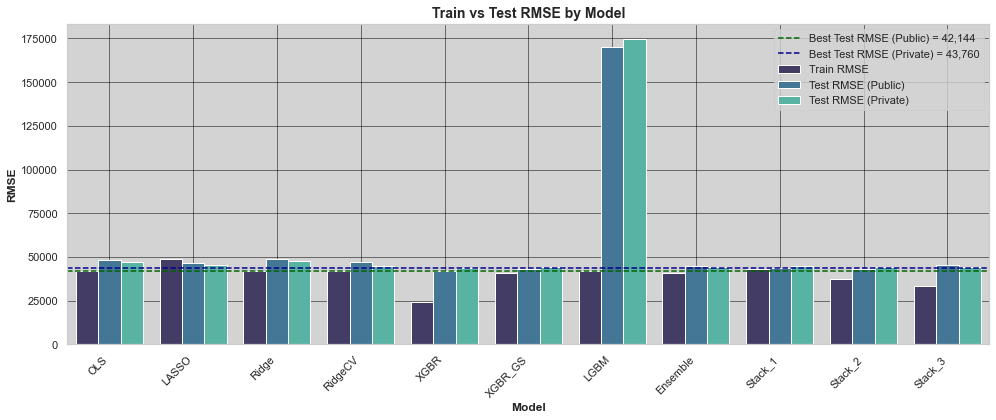

In [77]:
model_scores()